# Merging SRXs

In [43]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, HTML, display

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.io import add_table
from ncbi_remap.plotting import make_figs
from ncbi_remap.prealn_wf import srr_per_srx, srx_reproducibility_score
from ncbi_remap.normalization import cpm

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='prealn-wf_merge_srr')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

# Connect to data store
store = pd.HDFStore('../sra.h5')

# Constants
from ncbi_remap.prealn_wf import SPEARMAN_CUTOFF

last updated: 2018-01-19 
Git hash: 06f9cdb0e1127a415b918fe5173d6a65ca6975bf


In [61]:
Markdown(f"""
In the SRA, runs (SRR) are considered technical replicates. 
However, we have found instances where users have uploaded biological replicates or different samples as the same SRX. 
We want to provide browser tracks and summarized coverage counts at the library (SRX) level, requiring SRRs to be merged. 
Instead of blindly merging SRRs, we want to verify that SRRs within an SRX behave like a technical replicate. 
I have explored multiple criteria (including SERE), but I have settled on using pairwise Spearman correlation using genes with at least 1 read. 
Here I require a correlation of ≥{SPEARMAN_CUTOFF} for an SRR to be considered a technical replicate. 
I also require that all SRRs within an SRX behave like technical replicates. 
There are cases where an SRX has 3 or more SRR with a small fraction behaving differently. 
Currently I am excluding these SRXs, but it may be worth while to try to create pseudo SRXs made up of these different groups of SRRs that behave similarly.
""")


In the SRA, runs (SRR) are considered technical replicates. 
However, we have found instances where users have uploaded biological replicates or different samples as the same SRX. 
We want to provide browser tracks and summarized coverage counts at the library (SRX) level, requiring SRRs to be merged. 
Instead of blindly merging SRRs, we want to verify that SRRs within an SRX behave like a technical replicate. 
I have explored multiple criteria (including SERE), but I have settled on using pairwise Spearman correlation using genes with at least 1 read. 
Here I require a correlation of ≥0.95 for an SRR to be considered a technical replicate. 
I also require that all SRRs within an SRX behave like technical replicates. 
There are cases where an SRX has 3 or more SRR with a small fraction behaving differently. 
Currently I am excluding these SRXs, but it may be worth while to try to create pseudo SRXs made up of these different groups of SRRs that behave similarly.


## Number of SRRs Per SRX

In [62]:
cnts = srr_per_srx(store).srr.value_counts()
single = cnts[1]
multi = cnts.iloc[1:].sum()

Markdown(f"""
The majority of SRXs (n={single:,}) have a single SRR, while the remaning {multi:,} SRXs have more than one.
""")


The majority of SRXs (n=17,072) have a single SRR, while the remaning 2,602 SRXs have more than one.


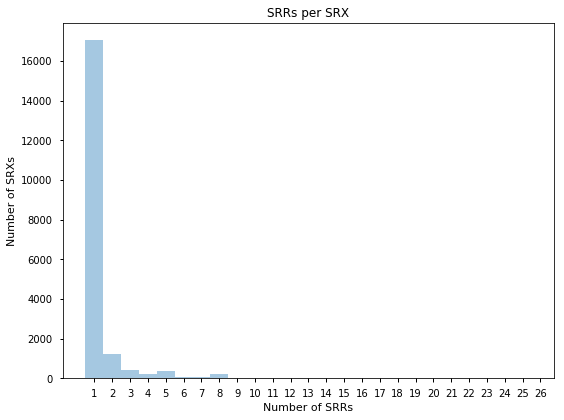

In [63]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('histogram_number_srr_per_srx'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    df = srr_per_srx(store).iloc[:, 0]
    bins = list(range(1, df.value_counts().index.max() + 1))
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df, bins=bins, ax=ax, kde=False, hist_kws={'align': 'left'})
    ax.set_title('SRRs per SRX')
    ax.set_ylabel('Number of SRXs')
    ax.set_xlabel('Number of SRRs')
    ax.set_xticks(bins)
    return fig

plot(store)

In [65]:
# Make Flags
srx_counts = srr_per_srx(store)
single_srr_srx = srx_counts[(srx_counts == 1)['srr']].index.tolist()
two_srr_srx = srx_counts[(srx_counts == 2)['srr']].index.tolist()
multi_srr_srx = srx_counts[(srx_counts > 2)['srr']].index.tolist()

srx_merge = set(single_srr_srx)

# Table of counts
df_num_srr = srx_counts.srr.value_counts().apply(lambda x: '{:,}'.format(x)).to_frame()
df_num_srr.index.name = 'Number of SRR'
df_num_srr.columns=['Number SRXs']

Markdown(f"""
{df_num_srr.to_html(classes="table table-striped")}
""")


<table border="1" class="dataframe table table-striped">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Number SRXs</th>
    </tr>
    <tr>
      <th>Number of SRR</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>17,072</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1,216</td>
    </tr>
    <tr>
      <th>3</th>
      <td>433</td>
    </tr>
    <tr>
      <th>5</th>
      <td>362</td>
    </tr>
    <tr>
      <th>8</th>
      <td>222</td>
    </tr>
    <tr>
      <th>4</th>
      <td>192</td>
    </tr>
    <tr>
      <th>6</th>
      <td>85</td>
    </tr>
    <tr>
      <th>7</th>
      <td>61</td>
    </tr>
    <tr>
      <th>9</th>
      <td>14</td>
    </tr>
    <tr>
      <th>13</th>
      <td>6</td>
    </tr>
    <tr>
      <th>10</th>
      <td>4</td>
    </tr>
    <tr>
      <th>14</th>
      <td>3</td>
    </tr>
    <tr>
      <th>15</th>
      <td>1</td>
    </tr>
    <tr>
      <th>12</th>
      <td>1</td>
    </tr>
    <tr>
      <th>11</th>
      <td>1</td>
    </tr>
    <tr>
      <th>26</th>
      <td>1</td>
    </tr>
  </tbody>
</table>


## Calculate Correlations

In [74]:
Markdown(f"""
For each SRX with multiple SRRs I calculate the pairwise Spearman correlations among SRRs.
For the {len(two_srr_srx):,} SRXs that have two SRRs, I remove SRXs whose SRRs have a correlation less than {SPEARMAN_CUTOFF}.
For the {len(multi_srr_srx):,} SRXs that have more than two SRRs, it is a more complicated metric could be used to select SRRS.
Currently I removing an SRX if any of the SRRs have less than {SPEARMAN_CUTOFF} spearman correlation.
""")


For each SRX with multiple SRRs I calculate the pairwise Spearman correlations among SRRs.
For the 1,216 SRXs that have two SRRs, I remove SRXs whose SRRs have a correlation less than 0.95.
For the 1,386 SRXs that have more than two SRRs, it is a more complicated metric could be used to select SRRS.
Currently I removing an SRX if any of the SRRs have less than 0.95 spearman correlation.


In [57]:
def calc_spearman(srx):
    counts = store.select('prealn/workflow/feature_counts/counts', 'srx == srx')
    corr = counts.unstack(1).corr(method='spearman')
    _min = corr.min().min()
    rows = []
    for k, v in corr.to_dict().items():
        res = []
        for kk, vv in v.items():
            if k == kk:
                continue
            res.append(f'{kk}:{round(vv, 2)}')
        rows.append({'srx': f'{srx}', 'srr': f'{k}', 'spearman': '|'.join(res), 'spearman_min': round(_min, 2)})
    return pd.DataFrame(rows).set_index(['srx', 'srr'])

@memory.cache
def iter_corr(srxs):
    
    dfs = []
    for srx in srxs:
        dfs.append(calc_spearman(srx))
    return pd.concat(dfs)

corrs = iter_corr(two_srr_srx + multi_srr_srx)

In [67]:
pairs_min = corrs.loc[(two_srr_srx, slice(None)), 'spearman_min'].groupby(level=0).min()
pairs_ok = (pairs_min >= SPEARMAN_CUTOFF).sum()
pairs_bad = (~(pairs_min >= SPEARMAN_CUTOFF)).sum()

Markdown(f"""
## Pairs of SRX

I started by looking at SRXs with a pair of SRRS (n={len(two_srr_srx):,}). 
The majority of these samples (n={pairs_ok:,}) have a Spearman correlation ≥{SPEARMAN_CUTOFF} and should be merged. 
The remaining {pairs_bad:,} will be removed from further analysis for now.
""")


## Pairs of SRX

I started by looking at SRXs with a pair of SRRS (n=1,216). 
The majority of these samples (n=894) have a Spearman correlation ≥0.95 and should be merged. 
The remaining 322 will be removed from further analysis for now.


In [81]:
# Calculate correalation and count ok
_df = pd.DataFrame([f'{pairs_ok:,}', f'{pairs_bad:,}'], index=[f'Merge (≥{SPEARMAN_CUTOFF})', f'Drop(<{SPEARMAN_CUTOFF})'], columns = ['Number of SRX'])
print('Cutoff: {}'.format(SPEARMAN_CUTOFF))
HTML(_df.to_html(classes="table table-striped"))

Cutoff: 0.95


,Number of SRX
Merge (≥0.95),894
Drop(<0.95),322


In [69]:
srx_merge |= set(pairs_min[pairs_min >= SPEARMAN_CUTOFF].index.values)

## More than 2 SRR per SRX

In [82]:
multi_min = corrs.loc[(multi_srr_srx, slice(None)), 'spearman_min'].groupby(level=0).min()
multi_ok = (multi_min >= SPEARMAN_CUTOFF).sum()
multi_bad = (~(multi_min >= SPEARMAN_CUTOFF)).sum()

Markdown(f"""
Next I looked at the {len(multi_srr_srx):,} SRXs that have 3 or more SRRs. 
Here I find {multi_ok:,} SRX that have a Spearman correlation ≥{SPEARMAN_CUTOFF} among all SRRs. 
The remaining {multi_bad:,} SRXs will be removed from further analysis. 
I breifly looked at these SRX that show some SRR with low correlation. 
There are a number of SRXs with a fraction of SRRs with low correlation, while the remaining SRRs have higher correlation; or examples where it looks like two groups of samples were merged together into a single SRX. 
It would be nice to revist this but for now I am going to ignore these samples.
""")


Next I looked at the 1,386 SRXs that have 3 or more SRRs. 
Here I find 321 SRX that have a Spearman correlation ≥0.95 among all SRRs. 
The remaining 1,065 SRXs will be removed from further analysis. 
I breifly looked at these SRX that show some SRR with low correlation. 
There are a number of SRXs with a fraction of SRRs with low correlation, while the remaining SRRs have higher correlation; or examples where it looks like two groups of samples were merged together into a single SRX. 
It would be nice to revist this but for now I am going to ignore these samples.


In [85]:
# Calculate correalation and count ok
_df = pd.DataFrame([f'{multi_ok:,}', f'{multi_bad:,}'], index=[f'Merge (≥{SPEARMAN_CUTOFF})', f'Drop(<{SPEARMAN_CUTOFF})'], columns = ['Number of SRX'])
print('Cutoff: {}'.format(SPEARMAN_CUTOFF))
HTML(_df.to_html(classes="table table-striped"))

Cutoff: 0.95


,Number of SRX
Merge (≥0.95),321
Drop(<0.95),"1,065"


In [86]:
srx_merge |= set(multi_min[multi_min >= SPEARMAN_CUTOFF].index.values)

## Create a list of mergable SRXs

In [87]:
flags = store['prealn/flags']
flags['flag_merge'] = False
flags.loc[(list(srx_merge), slice(None)), 'flag_merge'] = True
store['prealn/flags'] = flags

In [89]:
store.close()